# 🧬 BINND Complete Workflow - From Data to Decisions
This notebook demonstrates the complete workflow for DNA-DNA binding prediction using a BINND-like model. You'll be guided through:
1. Data preparation for your custom dataset.
2. Model training and evaluation.
3. Output analysis.

## Step 0: Environment Setup ⚙️

We're assuming you've successfully set up the Conda environment and are using it as your Jupyter kernel. This initial step is crucial!
The cell below will help confirm your setup and get our inference demonstration running:

1.  First, it changes the current working directory to `ROOT_DIR`. This ensures Python can properly locate all the necessary project files and scripts for the BINND model. Think of it like making sure you're in the right folder on your computer before running a program!
2.  Next, it executes the `sample_inference.py` script. This script runs a quick test inference. If your environment is set up correctly, you should see the inference output printed below without any errors.

In [7]:
from utils.paths import ROOT_DIR
%cd $ROOT_DIR
!python inference_demo/sample_inference.py

/home/gunavaran/Downloads/BINND
Using device: cuda
Model loaded successfully from /home/gunavaran/Downloads/BINND/inference_demo/BINND.pt

--- Inference Results ---
Sequence 1: AGCGATACGCCTTAACGTCT
Sequence 2: AATGGCGAAGGGGATCGTTC
Prediction: Bound, Probability: 0.9795


## Step 1: Preparing the Datasets 📊

To get started, you'll use a sample data.csv file (included when you clone this GitHub repository) located in ROOT_DIR/data/demo/. This file must contain three columns:

1. Seq1: Represents the first DNA sequence in a pair. **5' to 3` orientation**.
2. Seq2: Represents the second DNA sequence in a pair. Important: **5' to 3` orientation**.
3. Label: Indicates whether the sequence pair is binding or non-binding. Important: While the notebook assumes these column names for direct execution, the underlying source code can be readily adapted by users familiar with Python to accommodate different naming conventions.

The provided `data.csv` file contains 100,000 sequence pairs and their corresponding labels. In this initial step, we'll split the dataset into training, validation, and testing sets using an 8:1:1 ratio, respectively.

In [8]:
from utils.data_utils import stratified_split_dataset

data_dir = ROOT_DIR / 'data' / 'demo'
input_data_path = data_dir / 'data.csv'

stratified_split_dataset(csv_file_path=input_data_path,
                         label_column_name='Label',
                         out_dir_path=data_dir,
                         val_size=0.1,
                         test_size=0.1,
                         )

train_df shape:  (800000, 3)
test_df shape:  (100000, 3)
val_df shape:  (100000, 3)


The `stratified_split_dataset` function is designed to split your dataset into training, validation, and testing sets while preserving the original class distribution of the specified `label_column_name`. This ensures that each split (train, validation, test) proportionally represents the different categories (bound and unbound) present in your `Label` column, which is crucial for robust model training and evaluation, especially with imbalanced datasets.

The function takes the `csv_file_path`, the `label_column_name` (e.g., 'Label'), an `out_dir_path` for saving, and optional `test_size` and `val_size` parameters. It then saves the resulting `train.csv`, `val.csv`, and `test.csv` files to the specified output directory. You should now find these newly generated files in your `data_dir`.

## Step 2: Model Training 🚀

With our training, validation, and testing datasets ready, we're now set to train our BINND-like model!

During training, we'll need to specify locations to save the resulting trained model (so you can reuse it later for inference) and to store the training logs. These logs are essential for tracking the model's performance, convergence, and other important metrics throughout the training process.

In [9]:
import os
data_dir = ROOT_DIR / 'data' / 'demo'
checkpoint_dir = ROOT_DIR / 'experiments' / 'checkpoints' / 'demo'
log_dir = ROOT_DIR / 'experiments' / 'logs' / 'demo'

# Check if data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Data directory does not exist: {data_dir}")

# Create directories if they don't exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

For this workflow, we have two model architectures available:
1. BINND: This is the robust model fully described in the research article.
2. BINND-Lite: A more compact and lightweight version of BINND.

You can find the implementations for both of these architectures in `ROOT_DIR/src/networks/cnn.py`. For simplicity and faster execution within this notebook, we'll be using the BINND-Lite architecture.

In [10]:
network_name = "BINNDLite"
# change the network name to BINND if you want to use BINND's architecture

Before feeding our DNA sequences into the model, they need to be converted into a numerical format. We'll be using the 4xn_v2 encoding scheme for this, which is fully described in the associated research paper. You can find the implementation of this specific encoding method in  `ROOT_DIR/src/dataloader/datasets.py`.

In [11]:
encoder_name = "4xn_v2"

Since our primary goal for this immediate step is to train the model, we're setting up an important flags here:

In [12]:
is_train = True

### Configuring Training Hyperparameters ⚙️

As the final preparation step before we kick off training, we need to configure our hyperparameters. These values are crucial as they control the learning process itself, influencing everything from how fast your model learns to how often it saves progress.

Feel free to experiment with these values as you gain more experience, as tweaking them can significantly impact model performance and training time!

Here are the hyperparameters we'll be using:
- `max_seq_length` (int): The fixed length of input DNA sequences the model expects. The current implementation only supports 20 nucleotide long sequences.
- `batch_size` (int): Number of samples processed in one go.
- `log_interval` (int): How frequently (in batches) to print intermediate training/validation progress and log to files.
- `learning_rate` (float): (Only for training) The step size for the optimizer during training.
- `num_epochs` (int): (Only for training) The total number of full passes over the training dataset.
- `patience` (int): (Only for training) For early stopping; number of epochs to wait for validation loss improvement before stopping training.

We have kept the `num_epochs` small for faster completion of this demonstration. To potentially improve your model's performance, consider increasing this value.

In [23]:
max_seq_length = 20
batch_size = 512
learning_rate = 0.0004
num_epochs = 2
patience = 2
log_interval = 5

### Launching the Training Process! 🚀
Now for the exciting part! This cell generates and executes the command that initiates the entire training process for our BINND-like model.

We're carefully assembling a command line string (cmd_args) that passes all the configurations we just set (like data paths, network choice, and hyperparameters) to our main training script (main.py).

Once constructed, we'll print the full command so you can see exactly what's being run, and then execute it. This is where your model will start learning!

In [28]:
cmd_args = [
    "python", f"{ROOT_DIR}/main.py",
    "--data_dir", str(data_dir),
    "--checkpoint_dir", str(checkpoint_dir),
    "--log_dir", str(log_dir),
    "--network_name", network_name,
    "--encoder_name", encoder_name,
    "--max_seq_length", str(max_seq_length),
    "--batch_size", str(batch_size),
    "--log_interval", str(log_interval),
    "--learning_rate", str(learning_rate),
    "--num_epochs", str(num_epochs),
    "--patience", str(patience),
    "--is_train"
]
cmd = " ".join(cmd_args)
print(f"Running command:\n{cmd}")
os.system(cmd)

Running command:
python /home/gunavaran/Downloads/BINND/main.py --data_dir /home/gunavaran/Downloads/BINND/data/demo --checkpoint_dir /home/gunavaran/Downloads/BINND/experiments/checkpoints/demo --log_dir /home/gunavaran/Downloads/BINND/experiments/logs/demo --network_name BINNDLite --encoder_name 4xn_v2 --max_seq_length 20 --batch_size 512 --log_interval 5 --learning_rate 0.0004 --num_epochs 2 --patience 2 --is_train
Data Directory: /home/gunavaran/Downloads/BINND/data/demo
Network Name: BINNDLite
Encode Function Name: 4xn_v2
Max Sequence Length: 20
Batch Size: 512
Learning Rate: 0.0004
Number of Epochs: 2
Patience: 2
Checkpoint Directory: /home/gunavaran/Downloads/BINND/experiments/checkpoints/demo
Log Directory: /home/gunavaran/Downloads/BINND/experiments/logs/demo
Is Train: True
Is Test: False
Log Interval: 5
Using device: cuda
Total parameters: 1092225
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 

0

### Training Complete! 🎉
Congratulations! You've successfully trained your BINND-like model!

Your trained model that achieved the best performance during training can now be found in your `checkpoint_dir` under the name `best_model.pt`. This is the file you'll use for making future predictions!

Your `log_dir` is also now populated with several files that provide insights into your training session:
- `runtime_info.json`: A JSON file containing information about the training run, such as execution time and memory consumption.
- `train_log.csv`: A CSV file logging the training loss and accuracy per  `log_interval`.
- `val_log.csv`: A CSV file logging the validation loss and accuracy per  `log_interval`.
- `train_loss.png`: A plot visualizing the training loss over time.
- `train_accuracy.png`: A plot visualizing the training accuracy over time.
- `val_loss.png`: A plot visualizing the validation loss over time.
- `val_accuracy.png`: A plot visualizing the validation accuracy over time.

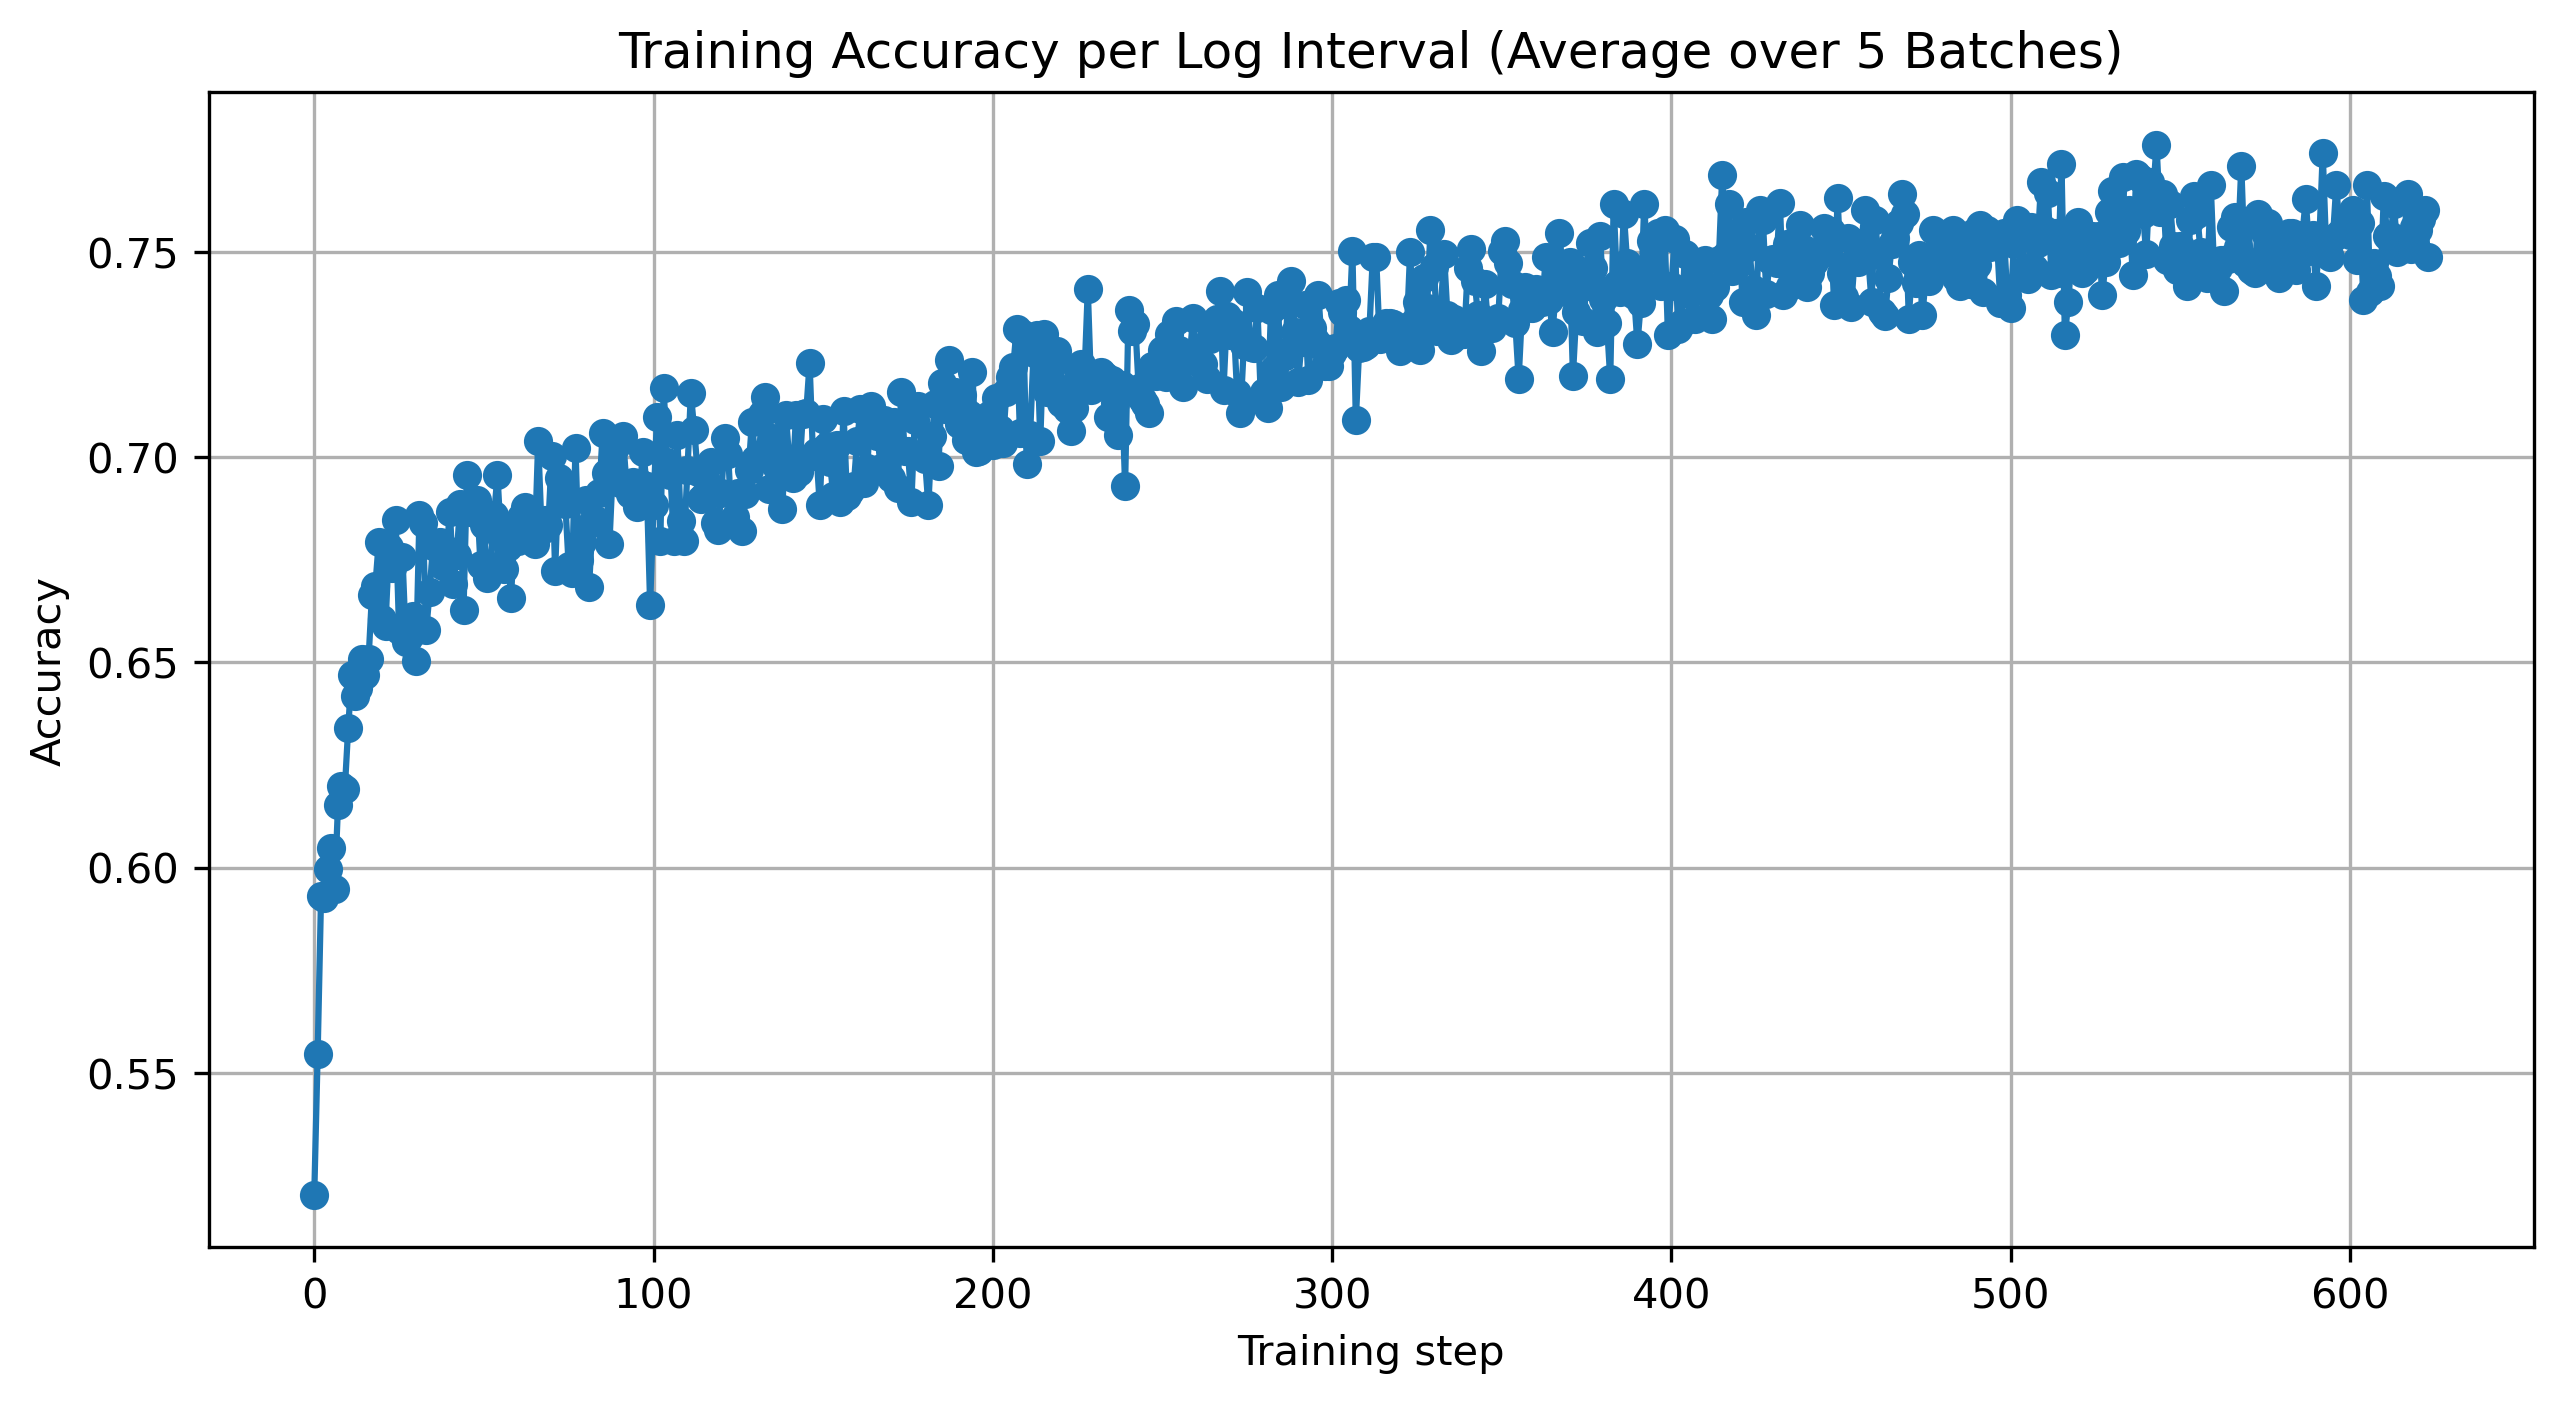

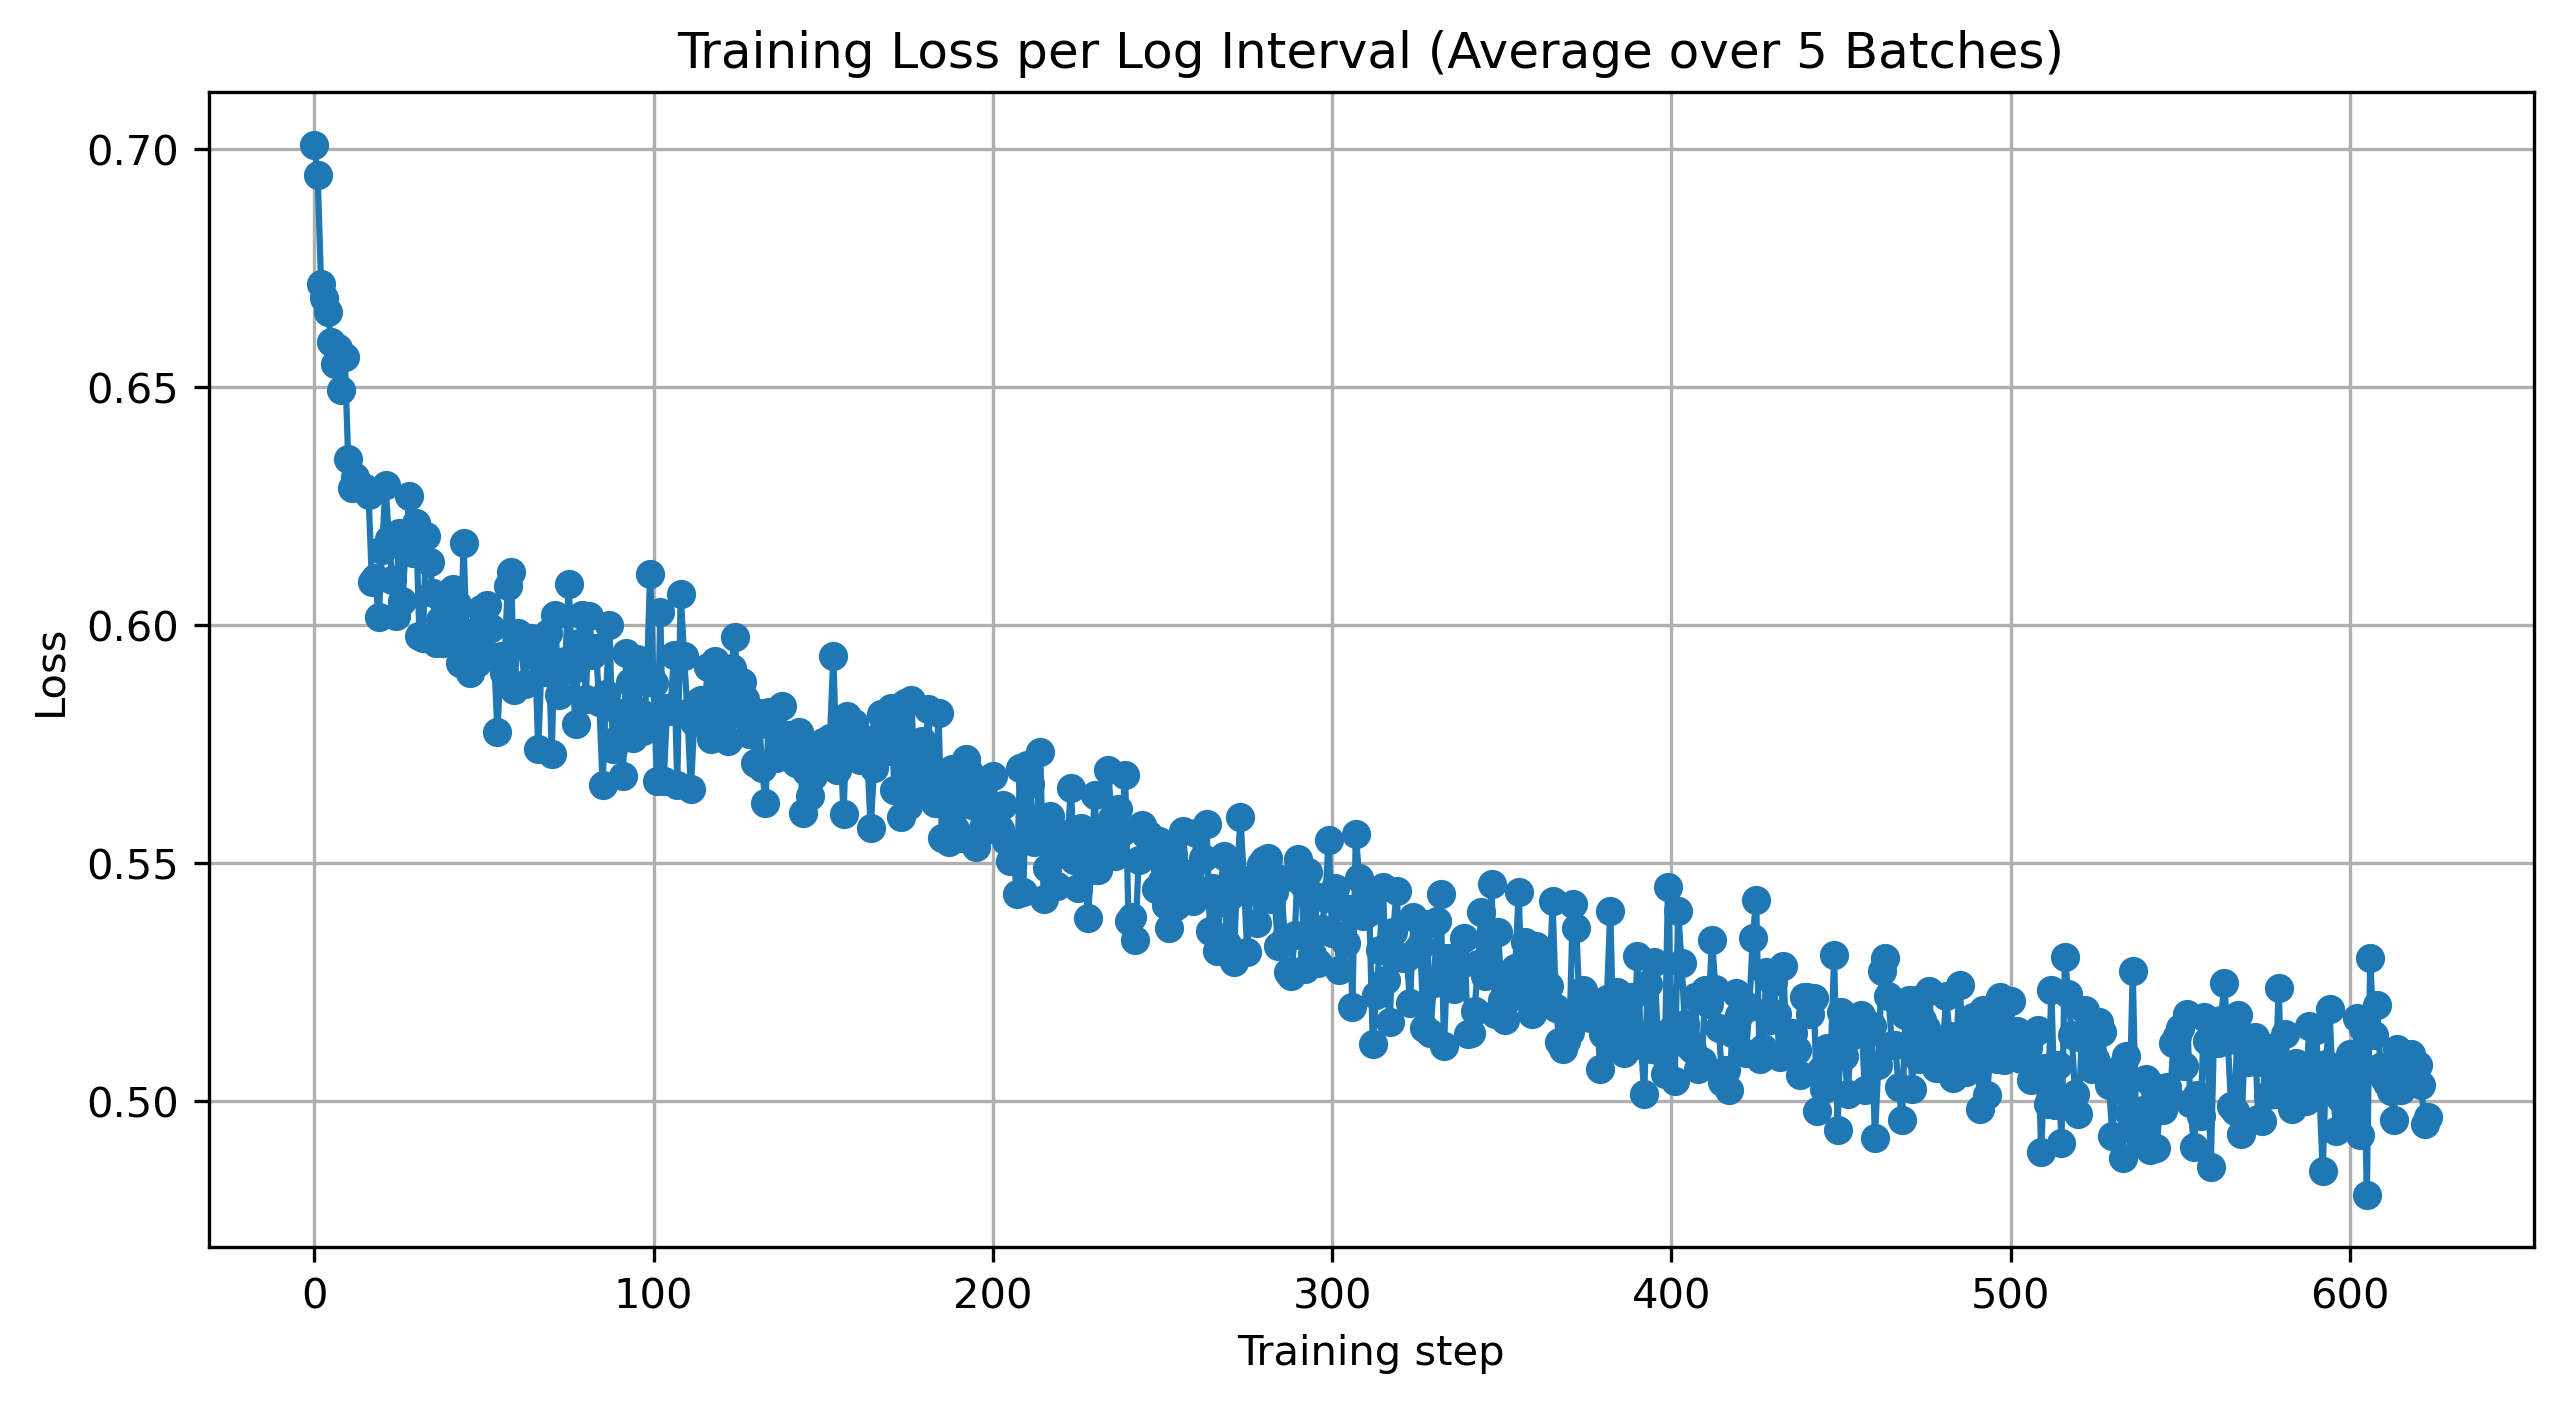

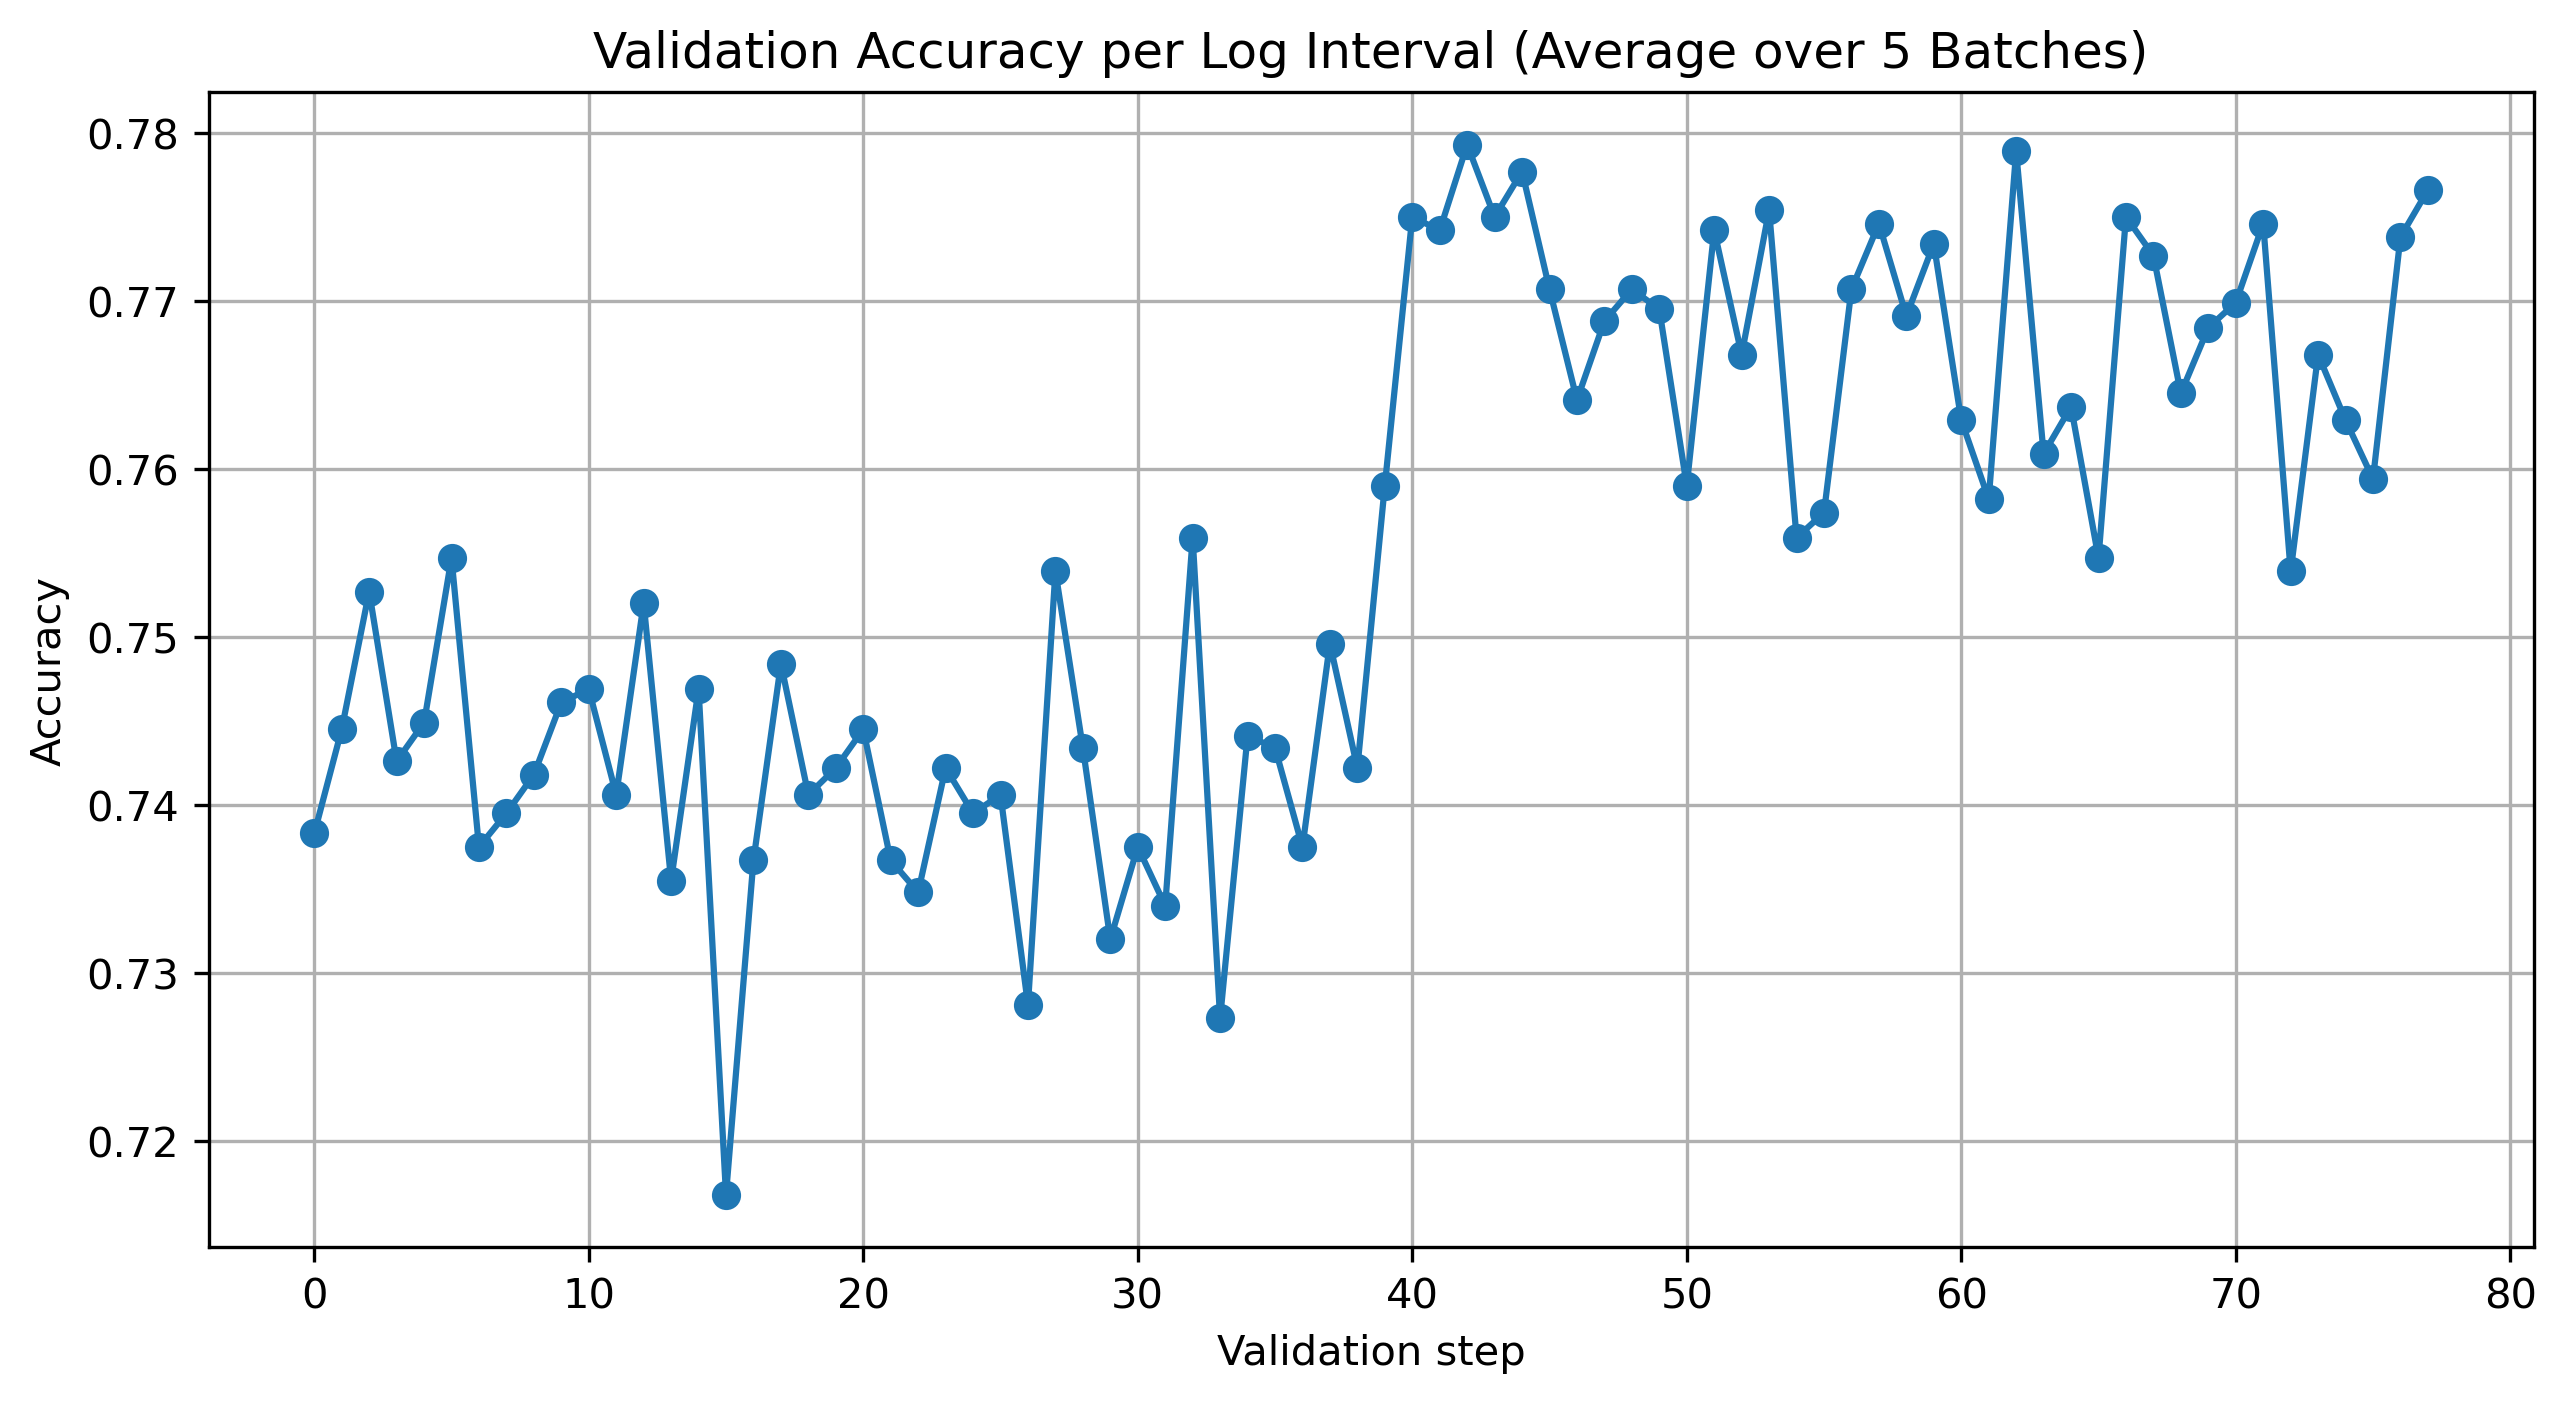

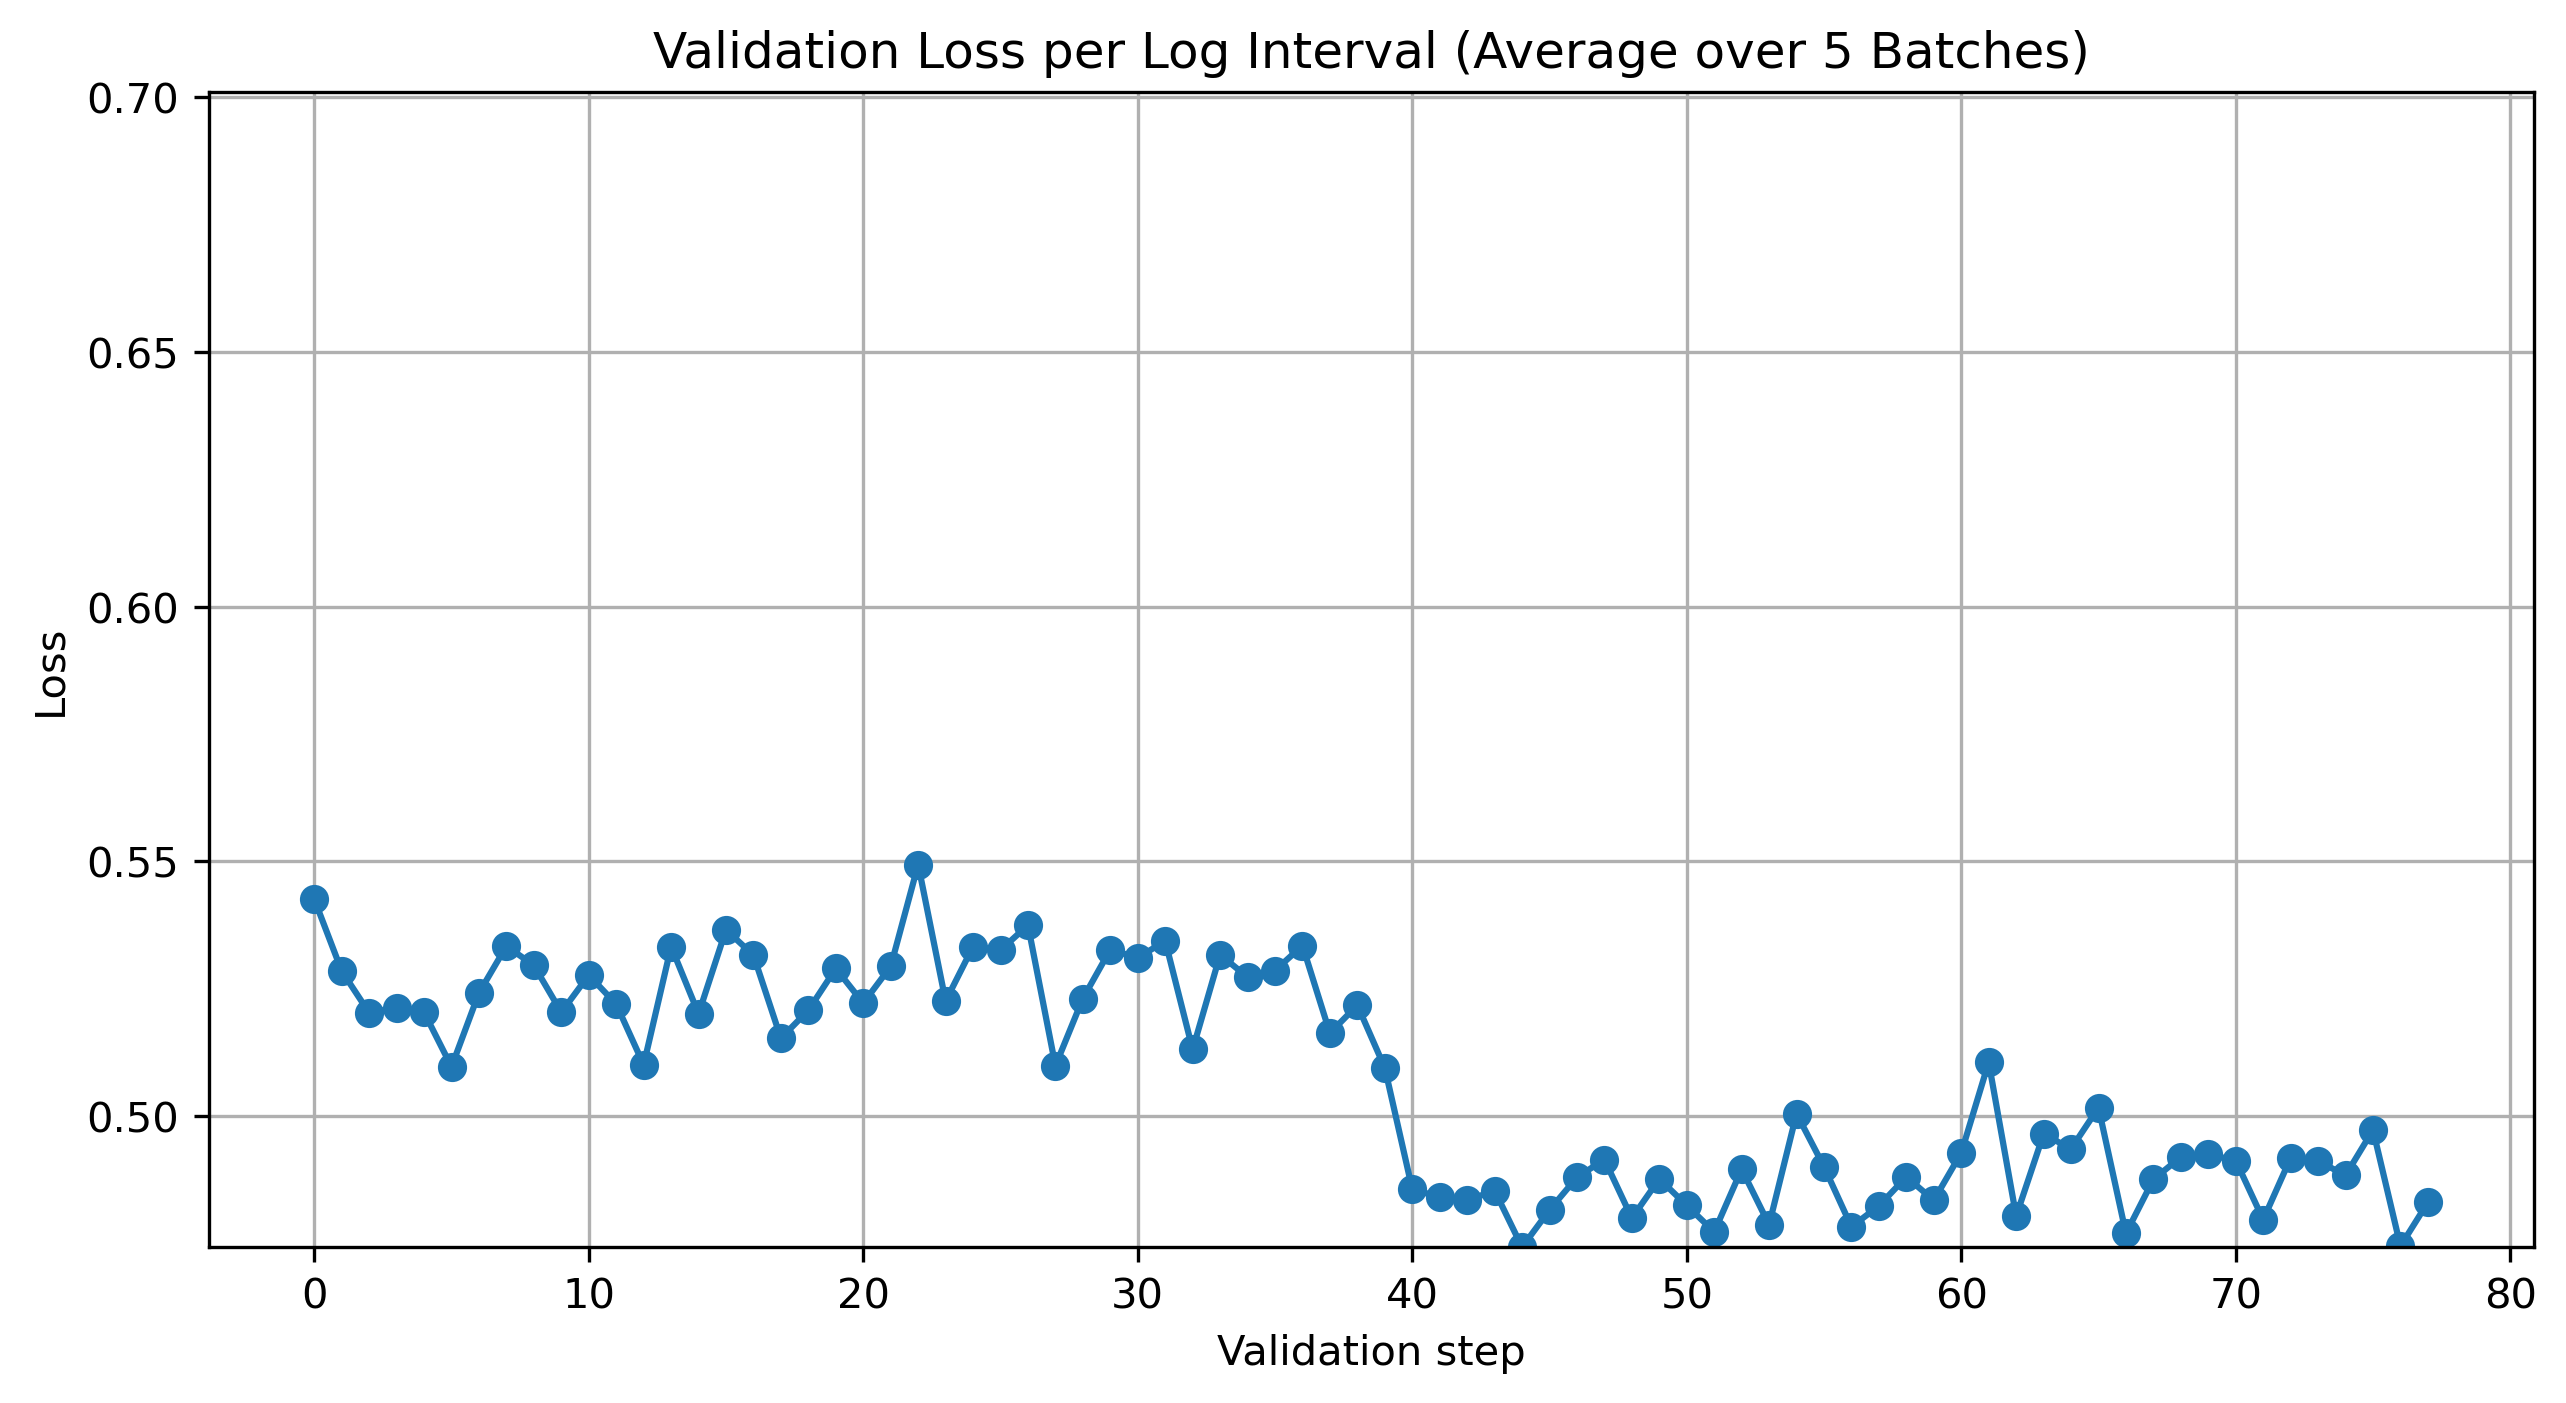

In [ ]:
from IPython.display import Image, display
display(Image(filename=f"{log_dir}/train_accuracy.png"))
display(Image(filename=f"{log_dir}/train_loss.png"))
display(Image(filename=f"{log_dir}/val_accuracy.png"))
display(Image(filename=f"{log_dir}/val_loss.png"))